In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
dist_central = np.loadtxt("CustDist_WHCentral.csv", skiprows=1, delimiter=",")[:,1:]
xy_central   = np.loadtxt("CustXY_WHCentral.csv", skiprows=1, delimiter=",")[:,1:].T

dist_corner  = np.loadtxt("CustDist_WHCorner.csv", skiprows=1, delimiter=",")[:,1:]
xy_corner    = np.loadtxt("CustXY_WHCorner.csv", skiprows=1, delimiter=",")[:,1:].T

orders       = np.loadtxt("CustOrd.csv", skiprows=1, delimiter=",")[:,1]

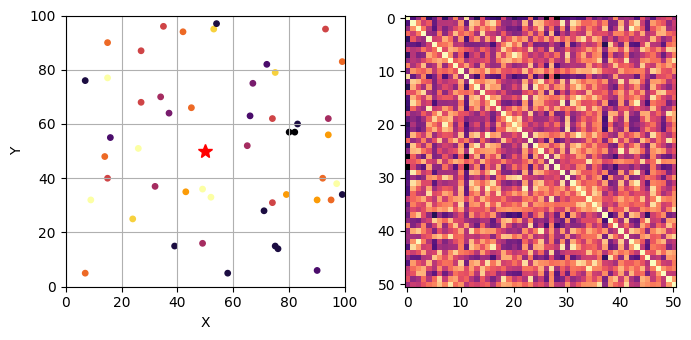

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3.5))

ax[0].set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))

ax[0].scatter(xy_central[0][1:], xy_central[1][1:], marker="o", s=15, c=orders[1:], cmap="inferno_r")
ax[0].plot(xy_central[0][0], xy_central[1][0], ls="", marker="*", ms=10, c="red")
ax[0].grid()

im = ax[1].imshow(dist_corner, cmap="magma_r")
# fig.colorbar(im, ax=ax[1])#, label='Interactive colorbar')
plt.tight_layout()

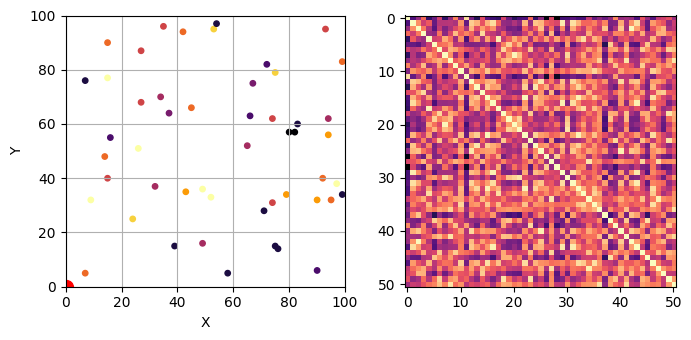

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3.5))

ax[0].set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))

ax[0].scatter(xy_corner[0][1:], xy_corner[1][1:], marker="o", s=15, c=orders[1:], cmap="inferno_r")
ax[0].plot(xy_corner[0][0], xy_corner[1][0], ls="", marker="o", ms=10, c="red")
ax[0].grid()

im = ax[1].imshow(dist_corner, cmap="magma_r")
# fig.colorbar(im, ax=ax[1])#, label='Interactive colorbar')
plt.tight_layout()

In [13]:
import random

from deap import base
from deap import creator
from deap import tools

In [52]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

IND_SIZE = 10

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(1, IND_SIZE+1), IND_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [152]:
def evaluate(individual, distances, orders, max_capacity=1000):
    
    dist = distances[0, individual[0]]
    capacity = max_capacity - orders[individual[0]]
    
    for i, f in zip(individual[:-1], individual[1:]):
        if capacity < orders[f]:
            dist += distances[i][0]
            capacity = max_capacity
            dist += distances[0][f]
            # print("Ups, go back")
        else:
            dist += distances[i][f]
        
        capacity -= orders[f]
        # print(f"Went from {i} to {f} and capacity is now {capacity} and dist is {dist}")        
    dist += distances[0, individual[-1]]
    return (dist,)
toolbox.register("evaluate", evaluate)

In [153]:
def plot_route(route, coords, orders, max_capacity=1000):
    fig, ax = plt.subplots(ncols=1, figsize=(4,4))

    ax.set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))
    ax.scatter(coords[:,0], coords[:,1], marker="o", s=15, c=orders, cmap="inferno_r")
    ax.plot(coords[0][0], coords[0][1], ls="", marker="o", ms=10, c="red")
    ax.grid()

    capacity = max_capacity - orders[route[0]]
    ax.annotate("", xytext=coords[0], xy=coords[route[0]], arrowprops=dict(arrowstyle="->"))
    
    for i, f in zip(route, route[1:]):
        if capacity < orders[f]:
            capacity = max_capacity
            ax.annotate("", xytext=coords[i], xy=coords[0], arrowprops=dict(arrowstyle="->"))
            ax.annotate("", xytext=coords[0], xy=coords[f], arrowprops=dict(arrowstyle="->"))
            # print("Ups, go back")
        else:
            ax.annotate("", xytext=coords[i], xy=coords[f], arrowprops=dict(arrowstyle="->"))

    ax.annotate("", xytext=coords[route[-1]], xy=coords[0], arrowprops=dict(arrowstyle="->"))
    

In [239]:
def PMX(ind1, ind2):
    ind1 -= 1
    ind2 -= 1
    tools.cxPartialyMatched(ind1, ind2)
    ind1 += 1
    ind2 += 1

    return (ind1, ind2)

toolbox.register("mate",   PMX)
toolbox.register("select", tools.selRoulette) 
# toolbox.register("select", tools.selTournament, tournsize=2) 
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.6)

# EVOLUTION

In [240]:
POP_SIZE = 50
CITIES = IND_SIZE
CXPB = 0.5
MUTPB = 0.2

population = toolbox.population(n=POP_SIZE)

fitnesses = list(map(lambda I: toolbox.evaluate(I, dist_central[:CITIES+1], orders[:CITIES+1]), population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

In [241]:
np.mean(fitnesses), np.min(fitnesses), np.max(fitnesses)

(541.46, 441.0, 628.0)

In [242]:
g = 0
means = []
mins = []
maxs = []
while g < 10_000/POP_SIZE:
    g += 1
    # print(f"----- Generation {g} -----")
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses   = list(map(lambda I: toolbox.evaluate(I, dist_central[:CITIES+1], orders[:CITIES+1]), population))
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    population[:] = offspring
        # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in population]

    mean = np.mean(fits)
    std  = np.std(fits)
    means.append(mean)
    mins.append(min(fits))
    maxs.append(max(fits))

    # print(f"Min {min(fits)}")
    # print(f"Max {max(fits)}")
    # print(f"Avg {mean}")
    # print(f"Std {std}")

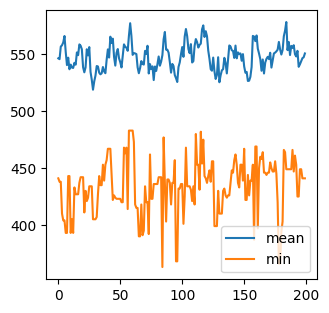

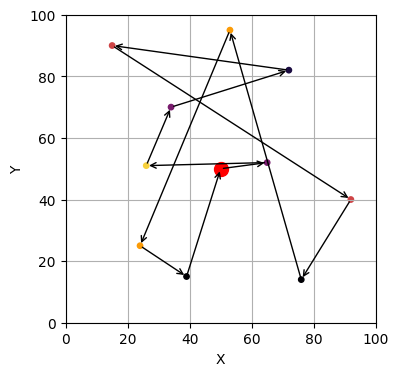

In [243]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.plot(means, label="mean")
ax.plot(mins, label="min")
ax.legend()
best = min(population, key=lambda x: x.fitness.values[0])
plot_route(best, xy_central.T[:11], orders[:11])

In [226]:
np.mean(fits)

491.44

In [228]:
offspring = toolbox.select(population, len(population))
fitnesses   = list(map(lambda I: toolbox.evaluate(I, dist_central[:CITIES+1], orders[:CITIES+1]), offspring))

np.mean(fitnesses)

559.0

In [67]:
def add1(ind):
    ind+=1

add1(population[0])

In [236]:
toolbox.select(population[:2],3)

[Individual([ 6,  1,  8,  4,  3,  5, 10,  9,  7,  2]),
 Individual([ 6,  1,  8,  4,  3,  5, 10,  9,  7,  2]),
 Individual([ 1,  6, 10,  3,  4,  5,  8,  7,  9,  2])]

In [238]:
population[0].fitness.values

(559.0,)